# Exploratory analysis of first dataset

Following columns were added (extracted) in this notebook:
* days_duration - how long did project's campaign last
* days_preparation - how long did project's campaign preparation last on Kickstarter
* days_running - how long did project's campaign run at time of the first scraping of the project
* days_remaining - (duration - running)
* usd_goal - project's goal in USD
* ratio_pledged_goal - ratio of money pledged at time of the first scraping of the project and goal
* ratio_pledged_end_goal - ratio of final money pledged and goal
* average_usd_pledge - average pledge per backer in USD at time of the first scraping of the project
* average_usd_pledge_end - final average pledge per backer in USD
* ratio_running_duration - ratio of days_running and days_duration

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# set default figsize
plt.rcParams['figure.figsize'] = [15, 6]

In [3]:
df_projects = pd.read_csv('data/projects_merged.csv', encoding='cp1252', index_col=0)
df_projects.info()

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65033 entries, 0 to 65037
Data columns (total 65 columns):
backers_count                65033 non-null int64
backers_count_end            65033 non-null int64
blurb                        65033 non-null object
blurb_end                    65031 non-null object
category                     65033 non-null object
category_end                 65033 non-null object
category_name                65033 non-null object
category_name_end            65033 non-null object
category_parent              65033 non-null object
category_parent_end          65033 non-null object
category_position            65033 non-null int64
category_position_end        65033 non-null int64
country                      65033 non-null object
created_at                   65033 non-null int64
creator                      65033 non-null object
creator_end                  65033 non-null object
creator_name                 65032 non-null object
creator_name_end             

In [4]:
# extract interesting info from timestamps
day_secs = 24 * 60 * 60
df_projects['days_duration'] = ((df_projects['deadline_end'] - df_projects['launched_at']) / day_secs).astype('int64')
df_projects['days_preparation'] = ((df_projects['launched_at'] - df_projects['created_at']) / day_secs).astype('int64')
df_projects['days_running'] = ((df_projects['scraped_at'] - df_projects['launched_at']) / day_secs).astype('int64')
df_projects['days_remaining'] = df_projects['days_duration'] - df_projects['days_running']

### Removing irrelevant data found during following exploratory data analysis


In [5]:
len(df_projects)

65033

In [6]:
# do not analyse canceled and suspended projects (-2506)
df_projects = df_projects[(df_projects['state_end'] == 'successful') | (df_projects['state_end'] == 'failed')]
len(df_projects)

62527

In [7]:
# this single project is successful even though it did not reach its goal (-1)
# https://www.kickstarter.com/projects/467587104/borders-of-the-imagination-an-epic-sci-fi-fantasy
df_projects.drop(5495, inplace=True)
len(df_projects)

62526

In [8]:
# a few projects lasted longer than 60 days (nowadays 60 days is maximum), we can drop them (-19)
df_projects = df_projects[df_projects['days_duration'] <= 60]
len(df_projects)

62507

## Exploratory data analysis

### End state

In [9]:
df_projects['state_end'].value_counts()

failed        36178
successful    26329
Name: state_end, dtype: int64

In [10]:
df_projects['state_end'].value_counts() / len(df_projects)

failed        0.578783
successful    0.421217
Name: state_end, dtype: float64

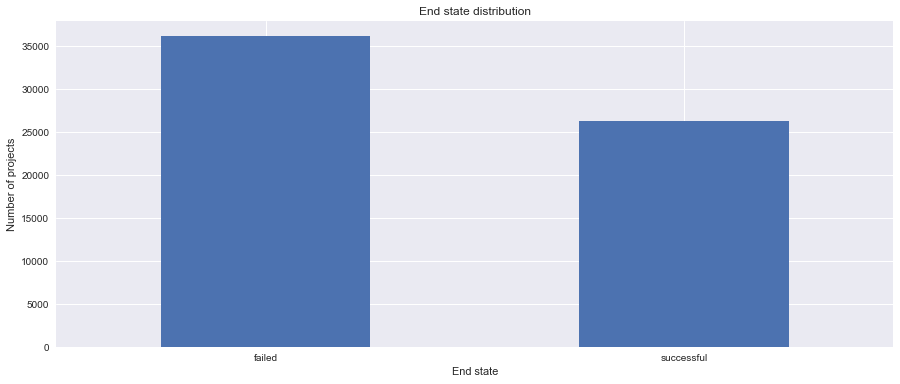

In [11]:
df_projects['state_end'].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.xlabel('End state')
plt.ylabel('Number of projects')
plt.title('End state distribution')

In [12]:
# 'spotlight_end' basicaly means 'is_successfull'
# https://www.kickstarter.com/spotlight?ref=faq_creator_spotlightwhat
# proof:
df_projects[(df_projects['spotlight_end']==True)].equals(df_projects[df_projects['state_end']=='successful'])

True

### Goal

As there are multiple currencies, we will convert money values to USD using static usd rate (available in dataset).

In [13]:
df_projects['static_usd_rate'].describe()

count    62507.000000
mean         0.995377
std          0.219424
min          0.009143
25%          1.000000
50%          1.000000
75%          1.000000
max          1.557361
Name: static_usd_rate, dtype: float64

In [14]:
# looks fine (usd = currency * static_usd_rate)
df_projects[['currency', 'static_usd_rate']].sample(10)

,currency,static_usd_rate
52863,SEK,0.113889
30371,USD,1.000000
32448,EUR,1.118631
3636,EUR,1.130865
10602,USD,1.000000
52344,EUR,1.061537
45904,USD,1.000000
7750,USD,1.000000
39429,GBP,1.223316
2759,USD,1.000000


In [15]:
df_projects['usd_goal'] = df_projects.apply(lambda x: int(x['goal']*x['static_usd_rate_end']), axis=1)

In [16]:
df_projects['usd_goal'].describe()

count    6.250700e+04
mean     5.782864e+04
std      1.266027e+06
min      0.000000e+00
25%      2.157500e+03
50%      6.324000e+03
75%      2.000000e+04
max      1.059990e+08
Name: usd_goal, dtype: float64

In [17]:
print('skewness    '+str(stats.skew(df_projects['usd_goal'])))
print('kutosis     '+str(stats.kurtosis(df_projects['usd_goal'])))

skewness    65.44210471556723
kutosis     4915.7651322535285


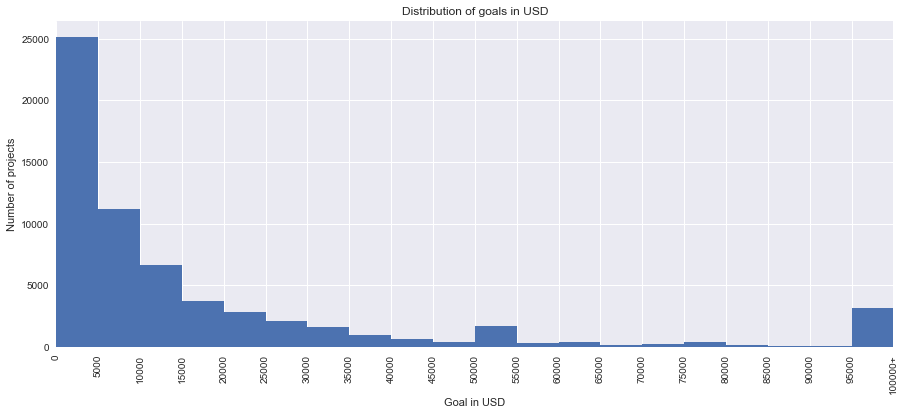

In [18]:
bins = np.arange(0,100500,5000)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['usd_goal'], bins[0], bins[-1]), bins=bins, )

labels = [str(x) for x in np.arange(0,100500,5000)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,100500,5000), labels, rotation='vertical')
plt.xlim([0, 100000])
plt.xlabel('Goal in USD')
plt.ylabel('Number of projects')
plt.title('Distribution of goals in USD')

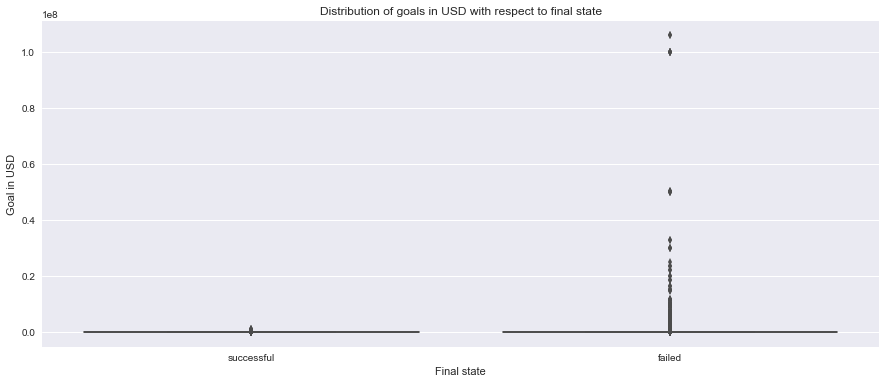

In [19]:
sns.boxplot(x=df_projects['state_end'], y=df_projects['usd_goal'])
plt.xlabel('Final state')
plt.ylabel('Goal in USD')
plt.title('Distribution of goals in USD with respect to final state')

(0, 100000.0)

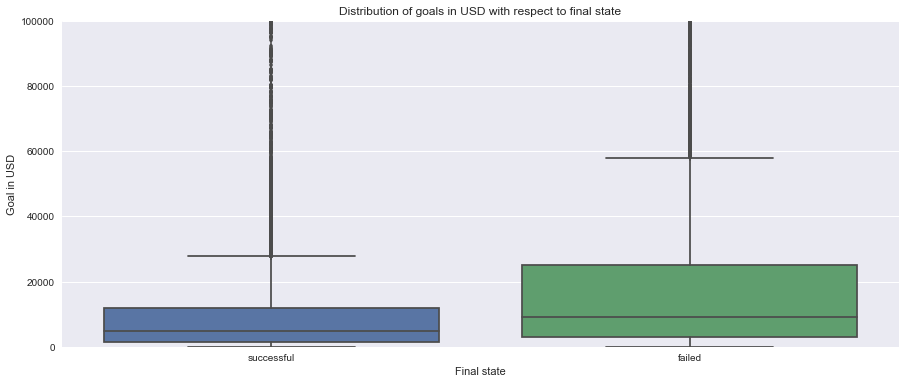

In [20]:
# higher goals have lower chances of success
sns.boxplot(x=df_projects['state_end'], y=df_projects['usd_goal'])
plt.xlabel('Final state')
plt.ylabel('Goal in USD')
plt.title('Distribution of goals in USD with respect to final state')
plt.ylim(0, 10e4)

In [21]:
# some projects have very low goals
df_projects[df_projects['usd_goal'] < 100]['usd_goal'].value_counts().head()

1     83
50    67
10    38
20    25
99    24
Name: usd_goal, dtype: int64

In [22]:
df_projects[df_projects['usd_goal'] < 100]['state_end'].value_counts()

successful    444
failed        140
Name: state_end, dtype: int64

In [23]:
# low goals transforms ALL-OR-NOTHING into KEEP-IT-ALL - this can cause some problems
len(df_projects[df_projects['usd_goal'] < 100])

584

### Live pledged amount

In [24]:
# already transformed into usd
df_projects['usd_pledged'].describe()

count    6.250700e+04
mean     8.712150e+03
std      8.449931e+04
min      0.000000e+00
25%      1.292517e+01
50%      3.800000e+02
75%      2.829355e+03
max      1.102400e+07
Name: usd_pledged, dtype: float64

In [25]:
print('skewness    '+str(stats.skew(df_projects['usd_pledged'])))
print('kutosis     '+str(stats.kurtosis(df_projects['usd_pledged'])))

skewness    64.8454385674794
kutosis     6562.771523457306


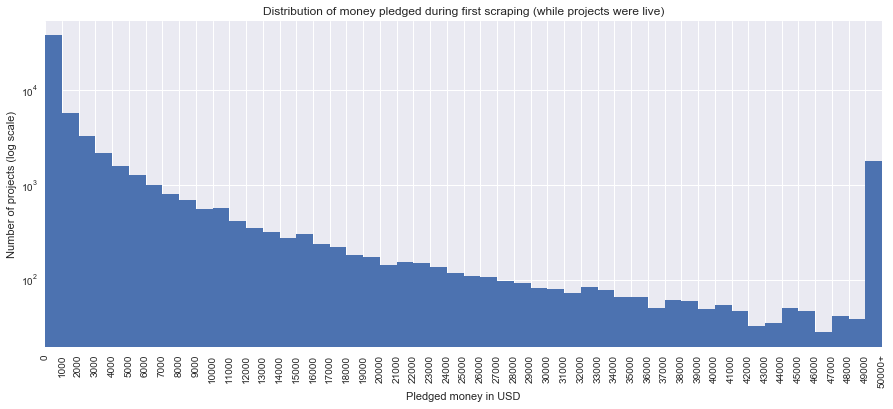

In [26]:
bins = np.arange(0,51000,1000)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['usd_pledged'], bins[0], bins[-1]), bins=bins, )

labels = [str(x) for x in np.arange(0,51000,1000)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,51000,1000), labels, rotation='vertical')
plt.xlim([0, 50000])

plt.xlabel('Pledged money in USD')
plt.ylabel('Number of projects (log scale)')
plt.title('Distribution of money pledged during first scraping (while projects were live)')

plt.yscale('log')

#### How many projects have already been successful during first scraping

In [27]:
(df_projects['usd_pledged'] >= df_projects['usd_goal']).value_counts()

False    51110
True     11397
dtype: int64

### Ratio of money pledged while live and goal

In [28]:
df_projects['ratio_pledged_goal'] = 100*df_projects['pledged']/df_projects['goal']

In [29]:
df_projects['ratio_pledged_goal'].describe()

count    6.250700e+04
mean     2.767850e+02
std      1.523874e+04
min      0.000000e+00
25%      1.000000e-01
50%      9.631579e+00
75%      6.601000e+01
max      3.156867e+06
Name: ratio_pledged_goal, dtype: float64

In [30]:
print('skewness    '+str(stats.skew(df_projects['ratio_pledged_goal'])))
print('kutosis     '+str(stats.kurtosis(df_projects['ratio_pledged_goal'])))

skewness    158.2404765402475
kutosis     30464.859617887247


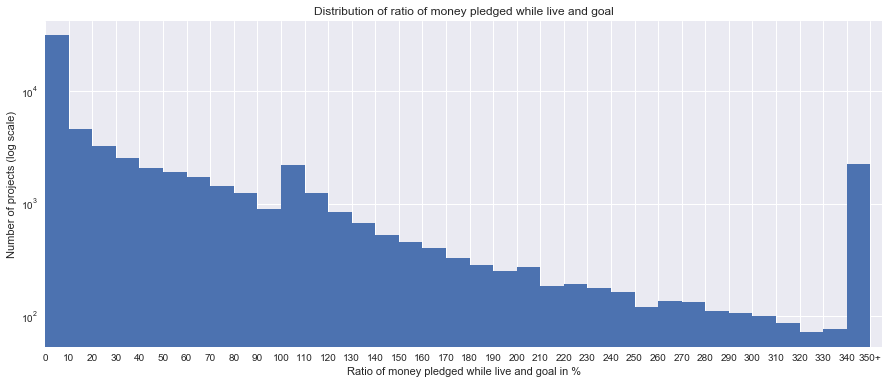

In [31]:
bins = np.arange(0,355,10)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['ratio_pledged_goal'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,355,10)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,355,10), labels, rotation='horizontal')
plt.xlim([0, 355])

plt.xlabel('Ratio of money pledged while live and goal in %')
plt.ylabel('Number of projects (log scale)')
plt.title('Distribution of ratio of money pledged while live and goal')

plt.yscale('log')

### Final pledged amount

In [32]:
df_projects['usd_pledged_end'].describe()

count    6.250700e+04
mean     1.538389e+04
std      1.287409e+05
min      0.000000e+00
25%      3.171932e+01
50%      7.465327e+02
75%      5.710395e+03
max      1.277984e+07
Name: usd_pledged_end, dtype: float64

In [33]:
print('skewness    '+str(stats.skew(df_projects['usd_pledged_end'])))
print('kutosis     '+str(stats.kurtosis(df_projects['usd_pledged_end'])))

skewness    47.12526306232452
kutosis     3557.6494498833104


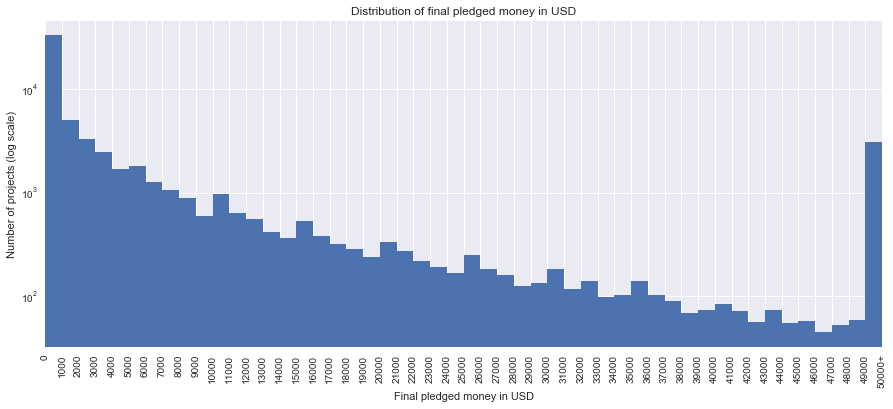

In [34]:
bins = np.arange(0,50500,1000)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['usd_pledged_end'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,50500,1000)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,50500,1000), labels, rotation='vertical')
plt.xlim([0, 50000])

plt.xlabel('Final pledged money in USD')
plt.ylabel('Number of projects (log scale)')
plt.title('Distribution of final pledged money in USD')

plt.yscale('log')

### Ratio of pledged_end and goal

In [35]:
df_projects['ratio_pledged_end_goal'] = 100*df_projects['pledged_end']/df_projects['goal']
df_projects['ratio_pledged_end_goal'].describe()

count    6.250700e+04
mean     6.298421e+02
std      4.267045e+04
min      0.000000e+00
25%      4.000000e-01
50%      1.920000e+01
75%      1.142000e+02
max      6.876410e+06
Name: ratio_pledged_end_goal, dtype: float64

In [36]:
print('skewness    '+str(stats.skew(df_projects['ratio_pledged_end_goal'])))
print('kutosis     '+str(stats.kurtosis(df_projects['ratio_pledged_end_goal'])))

skewness    141.5427188637603
kutosis     21994.47148464783


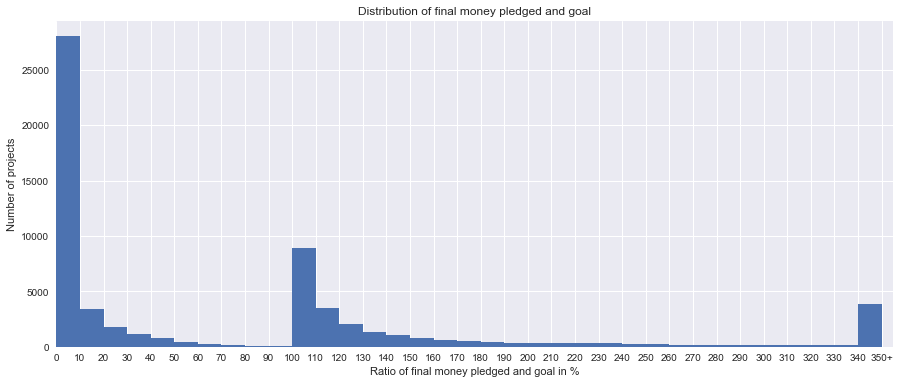

In [37]:
bins = np.arange(0,355,10)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['ratio_pledged_end_goal'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,355,10)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,355,10), labels, rotation='horizontal')
plt.xlim([0, 355])

plt.xlabel('Ratio of final money pledged and goal in %')
plt.ylabel('Number of projects')
plt.title('Distribution of final money pledged and goal')

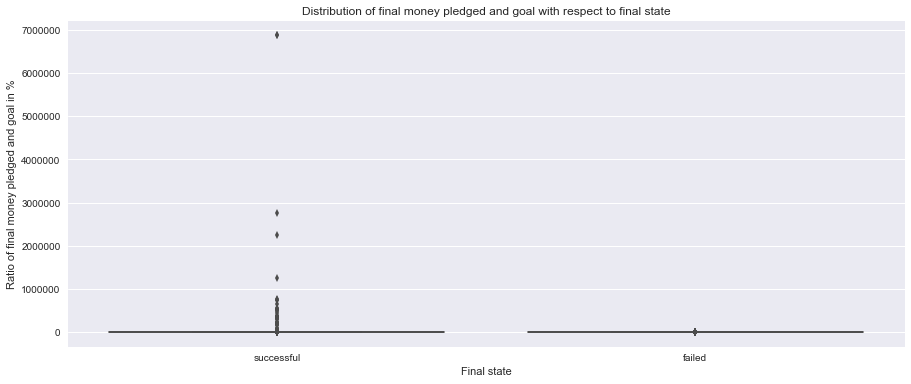

In [38]:
sns.boxplot(data=df_projects, x='state_end', y='ratio_pledged_end_goal')
#plt.ylim([-20, 370])
plt.xlabel('Final state')
plt.ylabel('Ratio of final money pledged and goal in %')
plt.title('Distribution of final money pledged and goal with respect to final state')

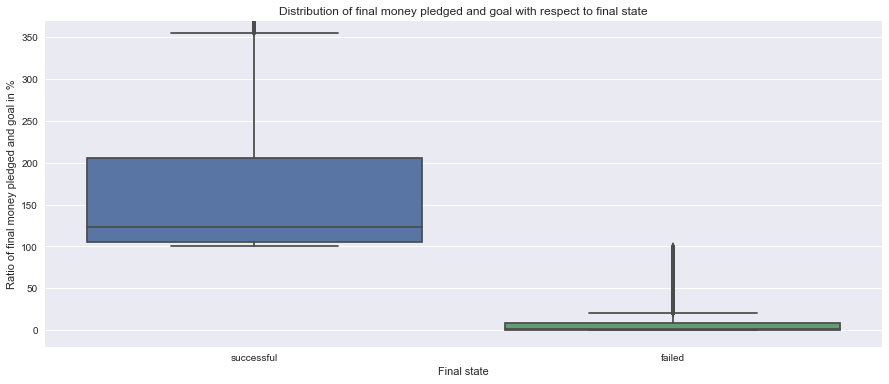

In [39]:
sns.boxplot(data=df_projects, x='state_end', y='ratio_pledged_end_goal')
plt.ylim([-20, 370])
plt.xlabel('Final state')
plt.ylabel('Ratio of final money pledged and goal in %')
plt.title('Distribution of final money pledged and goal with respect to final state')

#### Ratio of pledged_end and goal (successful)

In [40]:
df_projects[df_projects['state_end'] == 'successful']['ratio_pledged_end_goal'].describe()

count    2.632900e+04
mean     1.484864e+03
std      6.573787e+04
min      1.000000e+02
25%      1.059091e+02
50%      1.230769e+02
75%      2.057800e+02
max      6.876410e+06
Name: ratio_pledged_end_goal, dtype: float64

In [41]:
print('skewness    '+str(stats.skew(df_projects[df_projects['state_end'] == 'successful']['ratio_pledged_end_goal'])))
print('kutosis     '+str(stats.kurtosis(df_projects[df_projects['state_end'] == 'successful']['ratio_pledged_end_goal'])))

skewness    91.86421740771532
kutosis     9263.34328589111


In [42]:
df_projects[df_projects['state_end'] == 'successful'].sort_values(by=['ratio_pledged_end_goal'], ascending=False)[['name', 'usd_goal', 'usd_pledged_end']].head(20)

,name,usd_goal,usd_pledged_end
37100,Re-covering with Friends,1,68764.100000
37101,Re-covering with Friends,1,68764.100000
4437,CLOCKWRIGHT: Large-Scale Analogue Time Machines,1,27588.230000
34741,THE 'mi8' RISES | The Best Wireless Duo Stereo...,1,22603.000000
375,"Multi-Purpose, All-Occasion Greeting Cards",2,25150.300000
33675,Dice Set Felt Coasters,1,7548.000000
42050,Big Something Tumbleweed Pre-Order,1,7529.000000
42051,Big Something Tumbleweed Pre-Order,1,7529.000000
44630,The Horror and Sci-Fi Movie Prop Book,1,6435.000000
48649,HAIR TO THE THRONE,1,5607.000000


As we spotted earlier low goals transform ALL-OR-NOTHING into KEEP-IT-ALL. These projects then produce large outliers, which will affect prediction accuracy.

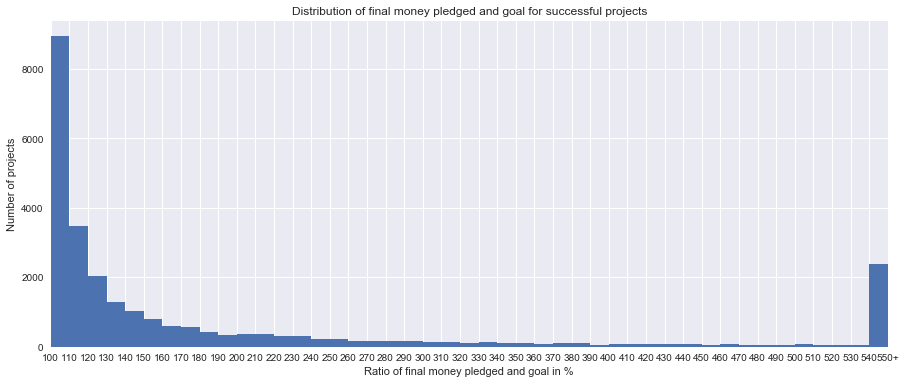

In [43]:
bins = np.arange(0,560,10)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects[df_projects['state_end'] == 'successful']['ratio_pledged_end_goal'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,560,10)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,560,10), labels, rotation='horizontal')
plt.xlim([100, 550])

plt.xlabel('Ratio of final money pledged and goal in %')
plt.ylabel('Number of projects')
plt.title('Distribution of final money pledged and goal for successful projects')

#### Ratio of pledged_end and goal (failed)

In [44]:
df_projects[df_projects['state_end'] == 'failed']['ratio_pledged_end_goal'].describe()

count    36178.000000
mean         7.588828
std         14.275313
min          0.000000
25%          0.013333
50%          0.883558
75%          8.000000
max         99.997417
Name: ratio_pledged_end_goal, dtype: float64

In [45]:
print('skewness    '+str(stats.skew(df_projects[df_projects['state_end'] == 'failed']['ratio_pledged_end_goal'])))
print('kutosis     '+str(stats.kurtosis(df_projects[df_projects['state_end'] == 'failed']['ratio_pledged_end_goal'])))

skewness    2.7329172007792804
kutosis     8.209845632712053


In [46]:
df_projects[(df_projects['state_end'] == 'failed') & (df_projects['ratio_pledged_end_goal'] > 95)][['name', 'usd_goal', 'usd_pledged_end']]

,name,usd_goal,usd_pledged_end
1450,Spooky Nation - Changing The World One Shirt A...,21321,20516.000000
5794,1 2 3 4 I declare a Pizza-War,37,36.379161
6453,Pyrex & Shookz - The Resume,711,710.898450
7260,The 5th Annual 90 Square Arts Festival,12000,11999.690000
13404,2016-2017 Fireball Newsflash Crosswords,8000,7904.000000
18852,"Spün - Calorie-Counting, Nutrition Tracking Ut...",150000,144453.000000
25699,18 Customizable Real Physical Buttons on a Fli...,22463,21493.586202
30484,Rainbow Illusion Playing Cards Version 2,6000,5932.230000
31398,Community Gardens in NYC: A Legal Primer,800,770.000000
38416,Remotsy | WiFi Remote for Alexa and SmartThings,15000,14470.000000


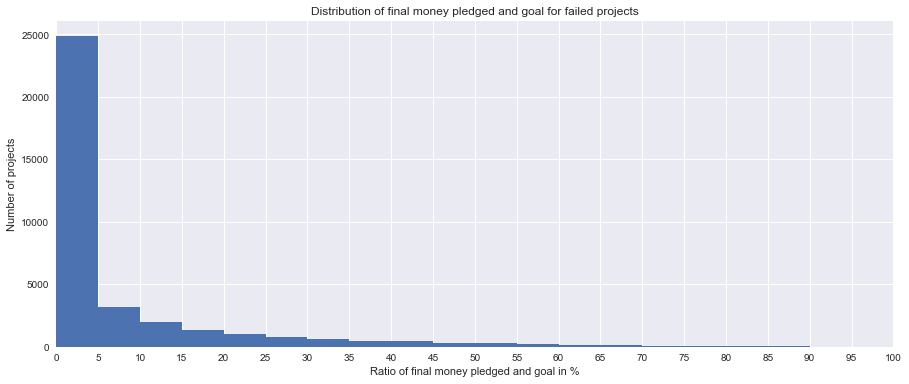

In [47]:
bins = np.arange(0,105,5)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects[df_projects['state_end'] == 'failed']['ratio_pledged_end_goal'], bins[0], bins[-1]), bins=bins)

plt.xticks(np.arange(0,105,5))
plt.xlim([0, 100])
plt.xlabel('Ratio of final money pledged and goal in %')
plt.ylabel('Number of projects')
plt.title('Distribution of final money pledged and goal for failed projects')

### Correlation between ratios

Pearson correlation: 0.833


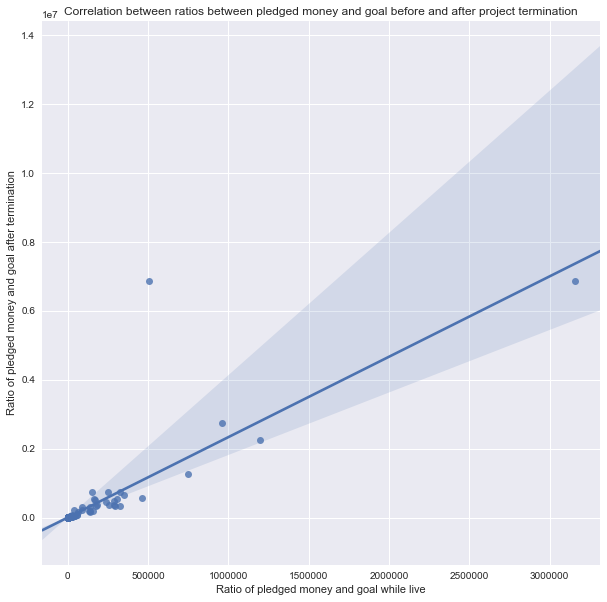

In [48]:
# looks interesting
plt.subplots(figsize=(10,10))
sns.regplot(x="ratio_pledged_goal", y="ratio_pledged_end_goal", data=df_projects)
print("Pearson correlation: %.3f" % df_projects['ratio_pledged_goal'].corr(df_projects['ratio_pledged_end_goal']))

plt.xlabel('Ratio of pledged money and goal while live')
plt.ylabel('Ratio of pledged money and goal after termination')
plt.title('Correlation between ratios between pledged money and goal before and after project termination')

## Average pledge per backer

In [49]:
df_projects['average_pledge'] = (df_projects['usd_pledged'] / df_projects['backers_count']).fillna(0)
df_projects['average_pledge'].describe()

count    62507.000000
mean        63.797304
std        128.445275
min          0.000000
25%          9.250074
50%         37.245890
75%         73.726192
max       5077.500000
Name: average_pledge, dtype: float64

In [50]:
print('skewness    '+str(stats.skew(df_projects['average_pledge'])))
print('kutosis     '+str(stats.kurtosis(df_projects['average_pledge'])))

skewness    12.321869997706717
kutosis     286.18281590916126


In [51]:
df_projects[df_projects['average_pledge'] >= 5000][['name','usd_goal','backers_count']]

,name,usd_goal,backers_count
20682,"Mountain Grounds, A Fully Emersive Cafe",150000,2
29590,The Next Great Place UPTOWNE Summit!,22000,1
30091,Deterrent- Feature Film,40000,1
49938,The Stealth P-7 electric commuter bike.,75693,3


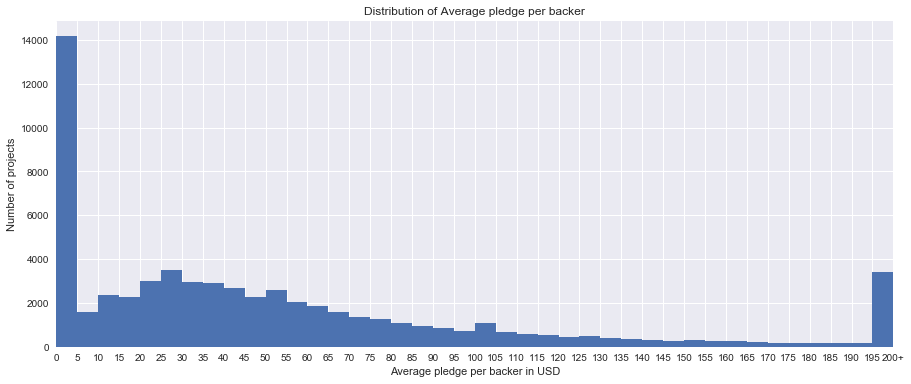

In [52]:
bins = np.arange(0,205,5)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['average_pledge'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,205,5)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,205,5), labels, rotation='horizontal')
plt.xlim([0, 200])

plt.xlabel('Average pledge per backer in USD')
plt.ylabel('Number of projects')
plt.title('Distribution of Average pledge per backer')

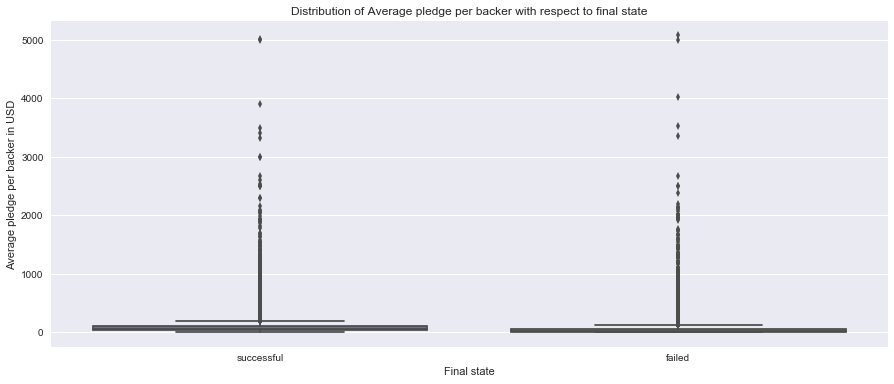

In [53]:
sns.boxplot(y=df_projects['average_pledge'], x=df_projects['state_end'])
plt.xlabel('Final state')
plt.ylabel('Average pledge per backer in USD')
plt.title('Distribution of Average pledge per backer with respect to final state')

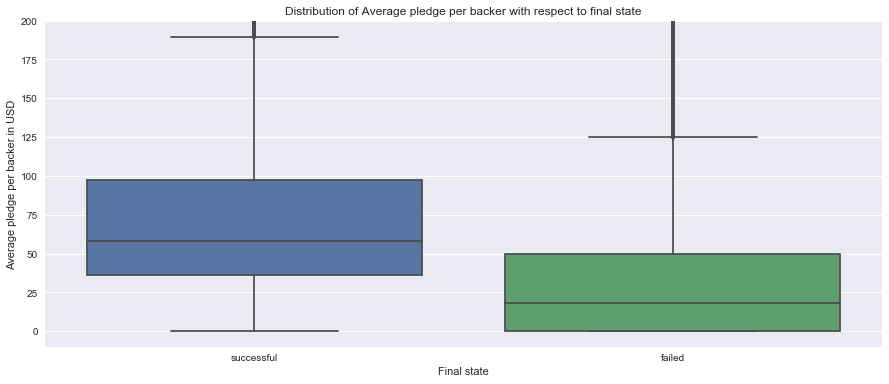

In [54]:
sns.boxplot(y=df_projects['average_pledge'], x=df_projects['state_end'])
plt.ylim([-10, 200])
plt.xlabel('Final state')
plt.ylabel('Average pledge per backer in USD')
plt.title('Distribution of Average pledge per backer with respect to final state')

Successful projects have higher average pledges

## Average pledge end

In [55]:
df_projects['average_pledge_end'] = (df_projects['usd_pledged_end'] / df_projects['backers_count_end']).fillna(0)
df_projects['average_pledge_end'].describe()

count    62507.000000
mean        70.273861
std        156.078670
min          0.000000
25%         13.250000
50%         40.333333
75%         80.000000
max      10000.000000
Name: average_pledge_end, dtype: float64

In [56]:
print('skewness    '+str(stats.skew(df_projects['average_pledge_end'])))
print('kutosis     '+str(stats.kurtosis(df_projects['average_pledge_end'])))

skewness    23.999238269916773
kutosis     1192.4724425442519


In [57]:
df_projects[df_projects['average_pledge_end'] >= 5000][['name','usd_goal','backers_count_end','usd_pledged_end']]

,name,usd_goal,backers_count_end,usd_pledged_end
9399,Patented (9 seasons) food enhancer,150000,1,10000.000000
10650,Coupon Creeper,250000,2,10025.000000
20775,The Commoner Princess,10000,1,10000.000000
43857,Save our heritage,21194,1,5311.291279
43858,Save our heritage,21194,1,5311.291279
53500,21st CENTURY MEDICAL PRACTICE SYSTEM THAT CHAN...,250000,1,10000.000000
53501,21st CENTURY MEDICAL PRACTICE SYSTEM THAT CHAN...,250000,1,10000.000000
60609,Hmm,15000,2,10023.000000


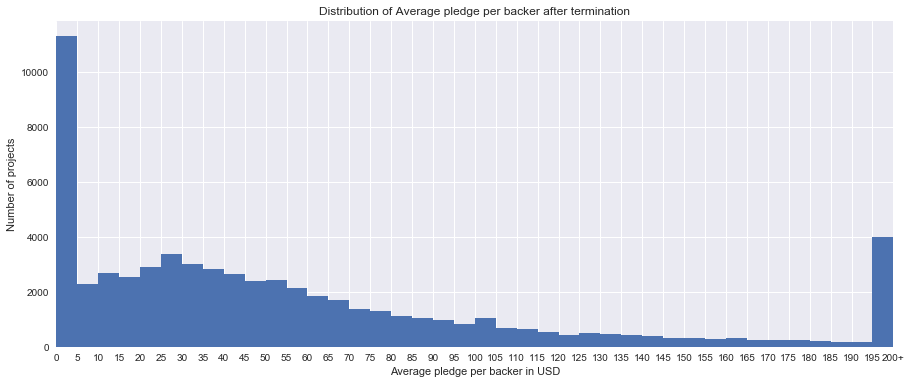

In [58]:
bins = np.arange(0,205,5)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['average_pledge_end'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,205,5)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,205,5), labels, rotation='horizontal')
plt.xlim([0, 200])

plt.xlabel('Average pledge per backer in USD')
plt.ylabel('Number of projects')
plt.title('Distribution of Average pledge per backer after termination')

#plt.yscale('log')

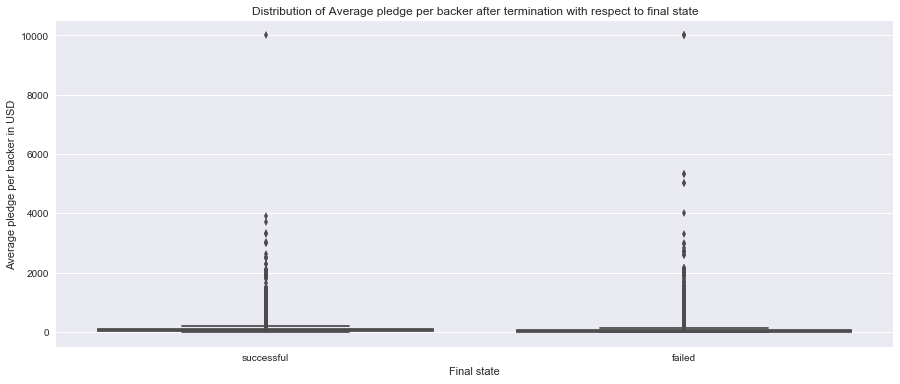

In [59]:
sns.boxplot(y=df_projects['average_pledge_end'], x=df_projects['state_end'])
plt.xlabel('Final state')
plt.ylabel('Average pledge per backer in USD')
plt.title('Distribution of Average pledge per backer after termination with respect to final state')

(-10, 250)

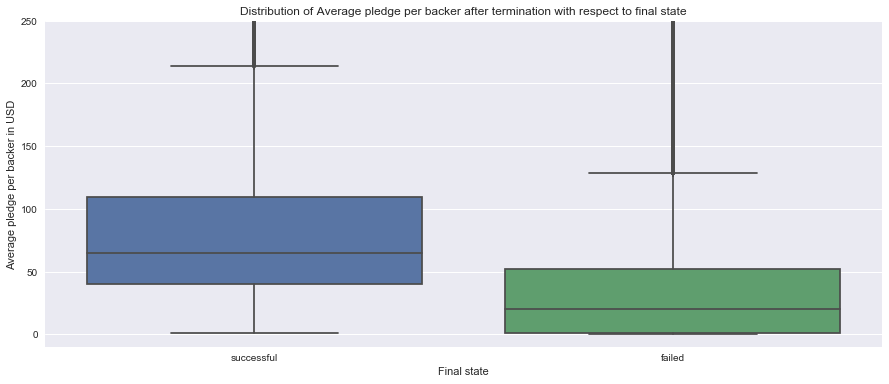

In [60]:
sns.boxplot(y=df_projects['average_pledge_end'], x=df_projects['state_end'])
plt.xlabel('Final state')
plt.ylabel('Average pledge per backer in USD')
plt.title('Distribution of Average pledge per backer after termination with respect to final state')
plt.ylim([-10, 250])

### Correlation between averages

Pearson correlation: 0.676


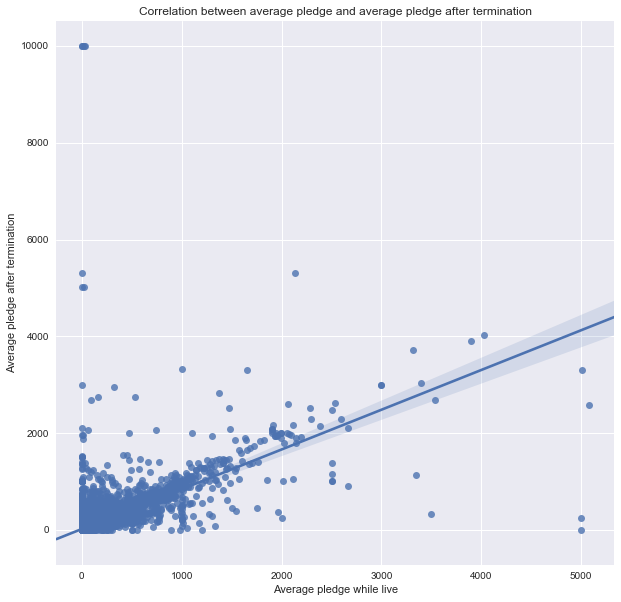

In [61]:
# could be much better
plt.subplots(figsize=(10,10))
sns.regplot(x="average_pledge", y="average_pledge_end", data=df_projects)
print("Pearson correlation: %.3f" % df_projects['average_pledge'].corr(df_projects['average_pledge_end']))

plt.xlabel('Average pledge while live')
plt.ylabel('Average pledge after termination')
plt.title('Correlation between average pledge and average pledge after termination')

### Campaign duration

In [62]:
df_projects['days_duration'].describe()

count    62507.000000
mean        36.467884
std         12.363244
min          2.000000
25%         30.000000
50%         30.000000
75%         45.000000
max         60.000000
Name: days_duration, dtype: float64

In [63]:
print('skewness    '+str(stats.skew(df_projects['days_duration'])))
print('kutosis     '+str(stats.kurtosis(df_projects['days_duration'], fisher=False)))

skewness    0.804631210254837
kutosis     2.687769490178312


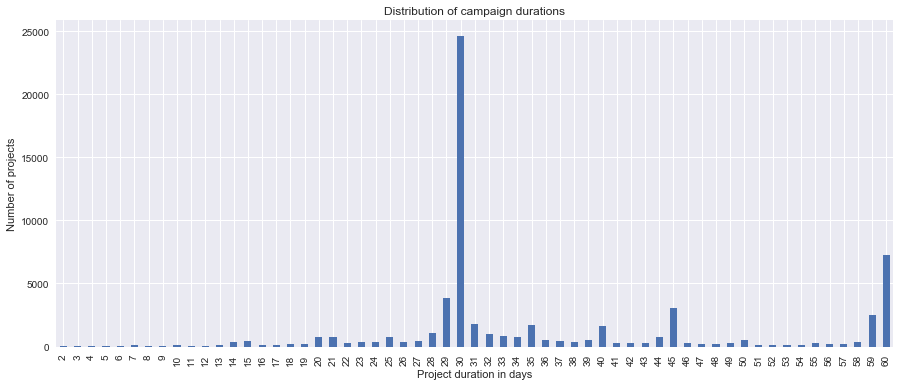

In [64]:
df_projects['days_duration'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Project duration in days')
plt.ylabel('Number of projects')
plt.title('Distribution of campaign durations')

In [65]:
df_projects[df_projects['days_duration'] <= 15]['days_duration'].value_counts()

15    428
14    349
10    137
7     113
13    102
12     55
11     44
9      38
6      30
8      23
5      22
4       2
3       2
2       1
Name: days_duration, dtype: int64

### Days running

In [66]:
df_projects['days_running'].describe()

count    62507.000000
mean        17.830867
std         12.860637
min          0.000000
25%          8.000000
50%         16.000000
75%         25.000000
max         59.000000
Name: days_running, dtype: float64

In [67]:
print('skewness    '+str(stats.skew(df_projects['days_running'])))
print('kutosis     '+str(stats.kurtosis(df_projects['days_running'], fisher=False)))

skewness    0.8668173846440906
kutosis     3.4847122234077625


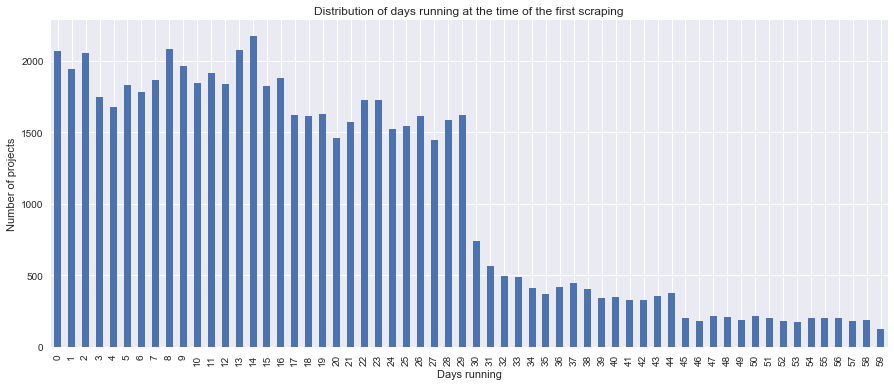

In [68]:
df_projects['days_running'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Days running')
plt.ylabel('Number of projects')
plt.title('Distribution of days running at the time of the first scraping')

### Ratio of days_running and days_duration

In [69]:
df_projects['ratio_running_duration'] = 100*df_projects['days_running']/df_projects['days_duration']
df_projects['ratio_running_duration'].describe()

count    62507.000000
mean        48.559464
std         28.949800
min          0.000000
25%         23.333333
50%         48.275862
75%         73.333333
max        100.000000
Name: ratio_running_duration, dtype: float64

In [70]:
print('skewness    '+str(stats.skew(df_projects['ratio_running_duration'])))
print('kutosis     '+str(stats.kurtosis(df_projects['ratio_running_duration'], fisher=False)))

skewness    0.013260928446038203
kutosis     1.8291668717273242


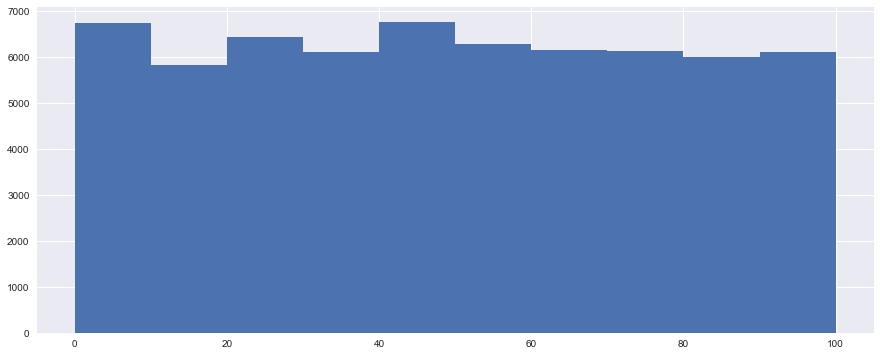

In [71]:
df_projects['ratio_running_duration'].hist()

We can see that relative times of first scraping are uniformly distributed along whole project lifes.

## Correlations

In [72]:
list(df_projects.select_dtypes([np.number]))

['backers_count',
 'backers_count_end',
 'category_position',
 'category_position_end',
 'created_at',
 'deadline_end',
 'goal',
 'id',
 'launched_at',
 'pledged',
 'pledged_end',
 'scraped_at',
 'state_changed_at',
 'state_changed_at_end',
 'static_usd_rate',
 'static_usd_rate_end',
 'usd_pledged',
 'usd_pledged_end',
 'days_duration',
 'days_preparation',
 'days_running',
 'days_remaining',
 'usd_goal',
 'ratio_pledged_goal',
 'ratio_pledged_end_goal',
 'average_pledge',
 'average_pledge_end',
 'ratio_running_duration']

In [73]:
cols=[
    'backers_count',
    'backers_count_end',
    'days_duration',
    'days_preparation',
    'days_running',
    'days_remaining',
    'usd_goal',
    'usd_pledged',
    'usd_pledged_end',
    'category_position',
    'category_position_end',
    'ratio_pledged_goal',
    'ratio_pledged_end_goal',
    'ratio_running_duration'
    ]

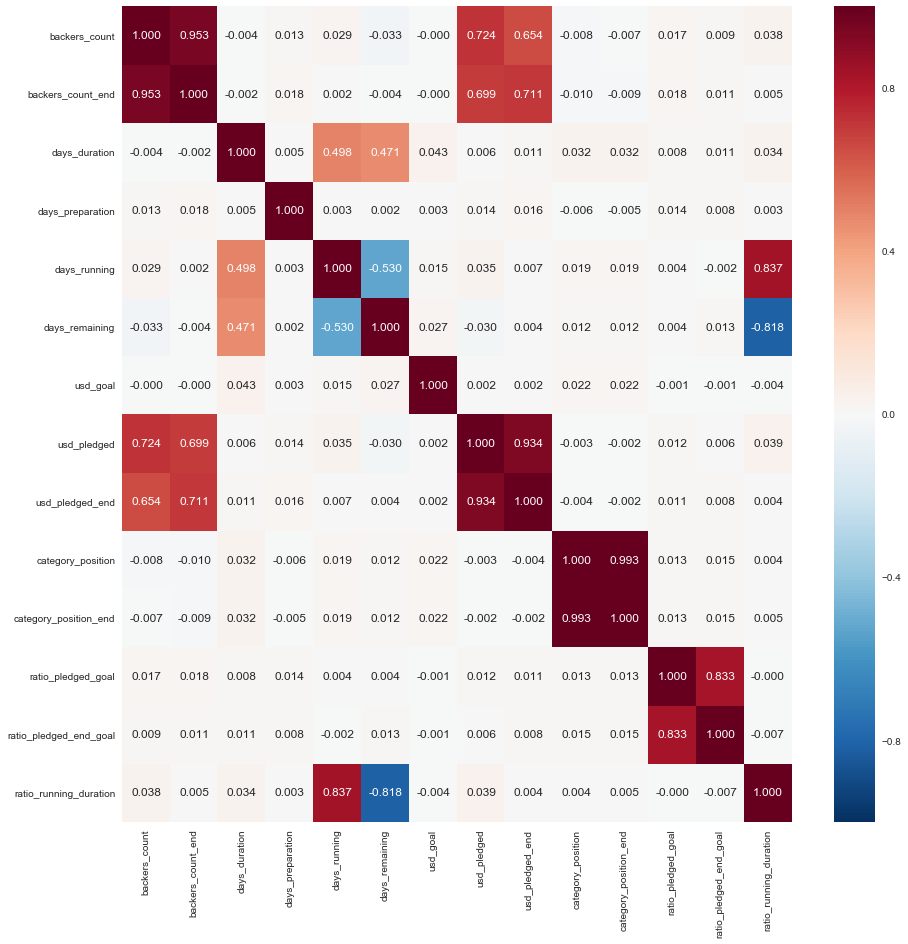

In [74]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_projects[cols].corr(), ax=ax, annot=True, fmt=".3f")

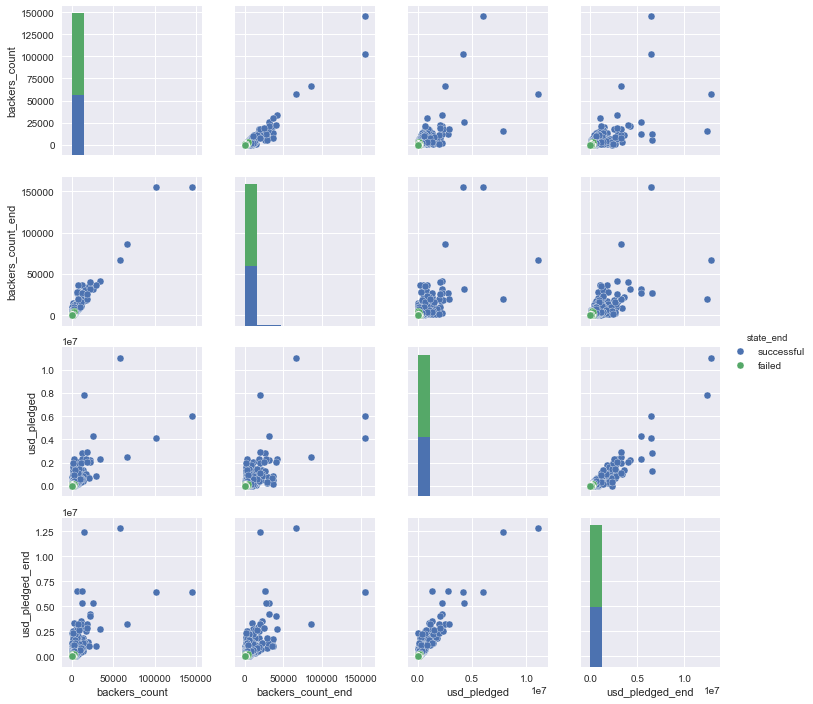

In [75]:
fig = sns.pairplot(df_projects[['backers_count', 'backers_count_end', 'usd_pledged', 'usd_pledged_end', 'state_end']], hue='state_end')
#plt.yscale('log')
#plt.xscale('log')

In [76]:
df_projects.to_csv('data/partly_analysed.csv')

# My legacy
### None of changes done here are used further. However, there might be some interesting information about dataset (some duplicates of previous analysis also).

### Numeric variables

In [5]:
df_projects.describe()

,backers_count,backers_count_end,category_position,category_position_end,created_at,deadline_end,goal,id,launched_at,pledged,pledged_end,scraped_at,state_changed_at,state_changed_at_end,static_usd_rate,static_usd_rate_end,usd_pledged,usd_pledged_end
count,65038.000000,65038.000000,65038.000000,65038.000000,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,65038.000000,65038.000000,6.503800e+04,6.503800e+04
mean,93.181801,159.475753,6.396199,6.404963,1.467838e+09,1.475652e+09,7.045290e+04,1.073002e+09,1.472475e+09,9.706526e+03,1.708096e+04,1.474044e+09,1.472475e+09,1.475610e+09,0.994714,0.994716,8.547335e+03,1.502729e+04
std,924.687360,1272.604621,4.300691,4.306053,2.076627e+07,1.672703e+07,1.474647e+06,6.193397e+08,1.677238e+07,8.741706e+04,1.353804e+05,1.670745e+07,1.677239e+07,1.672708e+07,0.220278,0.220277,8.302131e+04,1.264395e+05
min,0.000000,0.000000,1.000000,1.000000,1.266343e+09,1.446392e+09,1.000000e+00,1.852000e+04,1.441143e+09,0.000000e+00,0.000000e+00,1.446391e+09,1.441143e+09,1.446392e+09,0.009143,0.009143,0.000000e+00,0.000000e+00
25%,1.000000,2.000000,3.000000,3.000000,1.455334e+09,1.462058e+09,2.400000e+03,5.376639e+08,1.458759e+09,1.200000e+01,3.100000e+01,1.460686e+09,1.458759e+09,1.462036e+09,1.000000,1.000000,1.200000e+01,3.093878e+01
50%,7.000000,13.000000,5.000000,5.000000,1.467867e+09,1.475073e+09,7.000000e+03,1.072097e+09,1.471891e+09,3.860000e+02,7.510000e+02,1.473905e+09,1.471891e+09,1.474991e+09,1.000000,1.000000,3.700000e+02,7.187814e+02
75%,41.000000,75.000000,8.000000,8.000000,1.483904e+09,1.489795e+09,2.000000e+04,1.606240e+09,1.486687e+09,2.982000e+03,5.891750e+03,1.487201e+09,1.486687e+09,1.489787e+09,1.000000,1.000000,2.778168e+03,5.563885e+03
max,145232.000000,154926.000000,19.000000,19.000000,1.505473e+09,1.511283e+09,1.000000e+08,2.147422e+09,1.505523e+09,1.102400e+07,1.277984e+07,1.505514e+09,1.505523e+09,1.508084e+09,1.557361,1.557361,1.102400e+07,1.277984e+07


In [7]:
selected_cols = ['backers_count', 'goal', 'pledged', 'usd_pledged', 'backers_count_end', 'pledged_end', 'usd_pledged_end', 'state_end']
df_projects[selected_cols].head()

,backers_count,goal,pledged,usd_pledged,backers_count_end,pledged_end,usd_pledged_end,state_end
0,22,8000.0,1272.0,1272.0,87,8441.0,8441.0,successful
1,0,500.0,0.0,0.0,0,0.0,0.0,failed
2,1,25000.0,50.0,50.0,3,70.0,70.0,failed
3,1,600.0,30.0,30.0,22,904.0,904.0,successful
4,5,600.0,306.0,306.0,22,904.0,904.0,successful


In [8]:
df_projects[selected_cols].describe()

,backers_count,goal,pledged,usd_pledged,backers_count_end,pledged_end,usd_pledged_end
count,65038.000000,6.503800e+04,6.503800e+04,6.503800e+04,65038.000000,6.503800e+04,6.503800e+04
mean,93.181801,7.045290e+04,9.706526e+03,8.547335e+03,159.475753,1.708096e+04,1.502729e+04
std,924.687360,1.474647e+06,8.741706e+04,8.302131e+04,1272.604621,1.353804e+05,1.264395e+05
min,0.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1.000000,2.400000e+03,1.200000e+01,1.200000e+01,2.000000,3.100000e+01,3.093878e+01
50%,7.000000,7.000000e+03,3.860000e+02,3.700000e+02,13.000000,7.510000e+02,7.187814e+02
75%,41.000000,2.000000e+04,2.982000e+03,2.778168e+03,75.000000,5.891750e+03,5.563885e+03
max,145232.000000,1.000000e+08,1.102400e+07,1.102400e+07,154926.000000,1.277984e+07,1.277984e+07


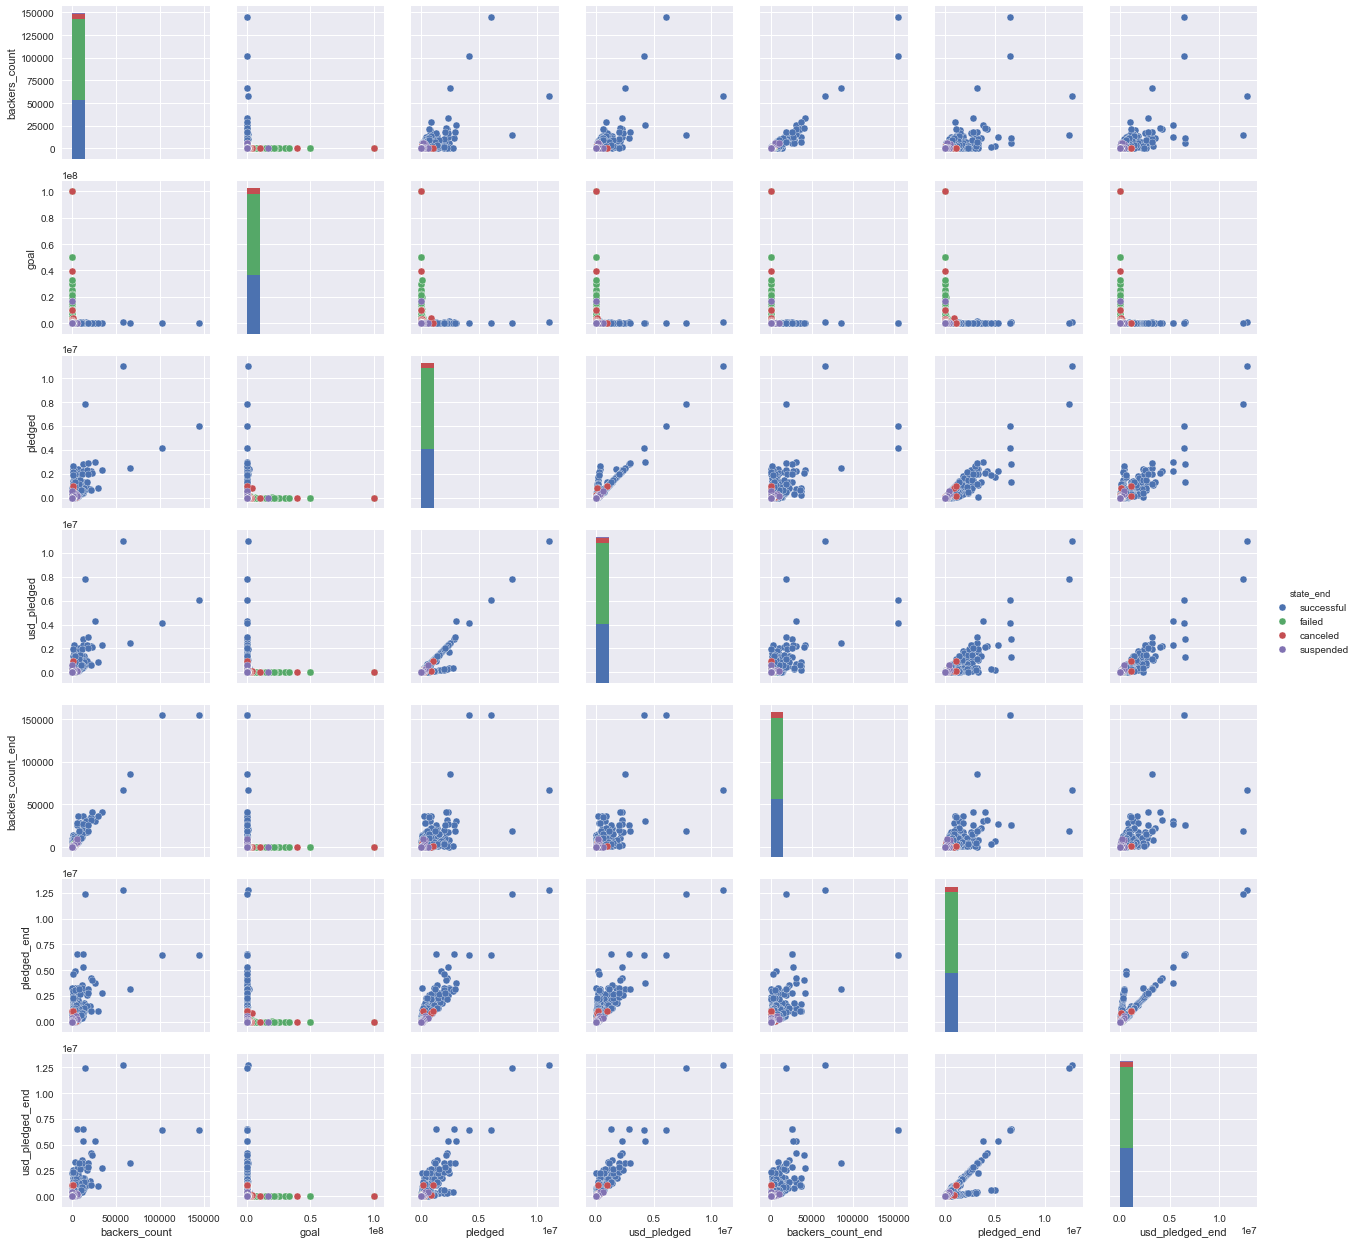

In [9]:
figure = sns.pairplot(df_projects[selected_cols], hue='state_end')

In [10]:
figure.savefig('figure.png', format='png', dpi=200)

#### backers_count

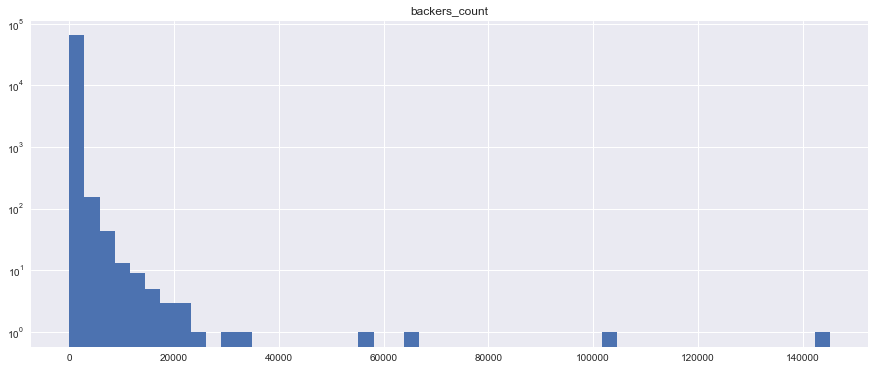

In [11]:
df_projects.hist(column='backers_count', bins=50)
plt.yscale('log')

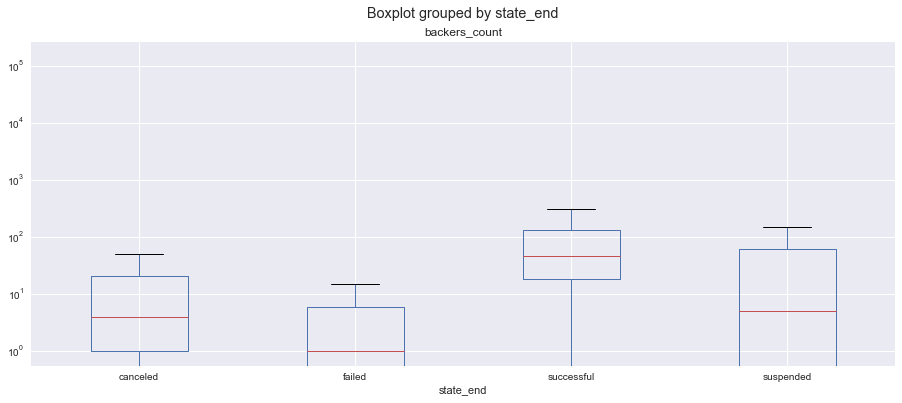

In [12]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

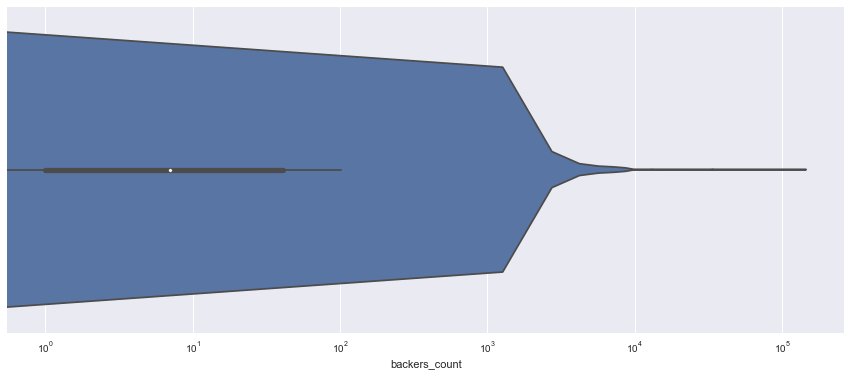

In [13]:
sns.violinplot(df_projects['backers_count'], width=20)
plt.xscale('log')

#### goal

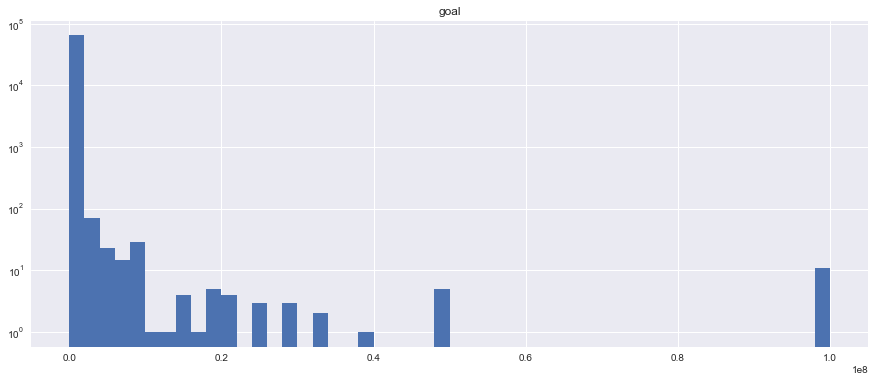

In [14]:
df_projects.hist(column='goal', bins=50)
plt.yscale('log')

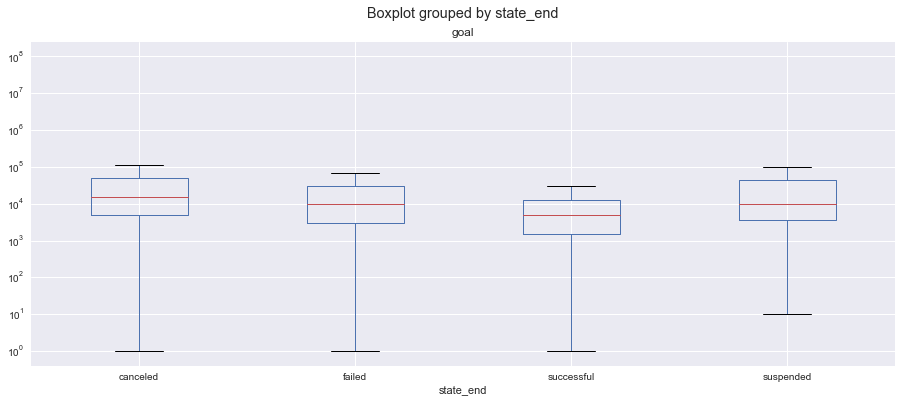

In [15]:
bp = df_projects.boxplot(column='goal', by='state_end')
plt.yscale('log')

#### pledged

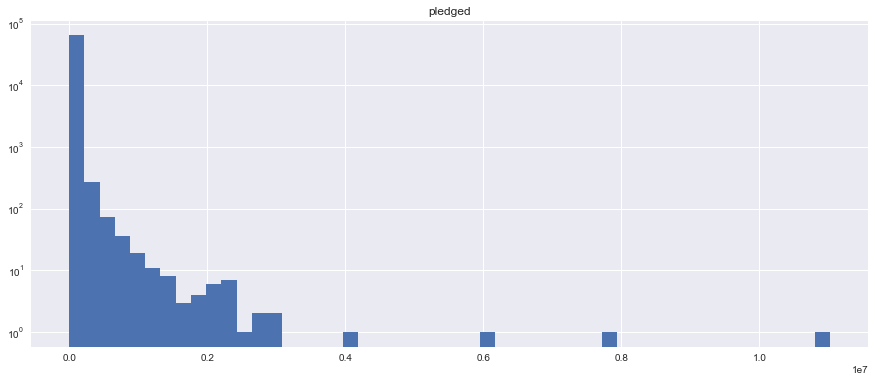

In [16]:
df_projects.hist(column='pledged', bins=50)
plt.yscale('log')

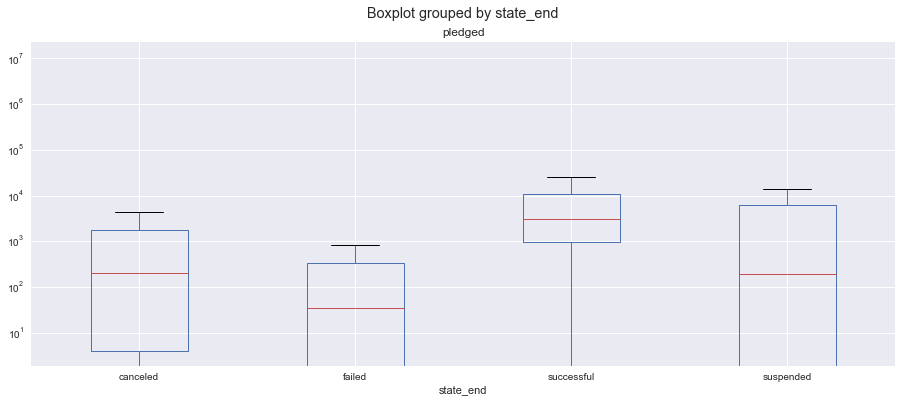

In [17]:
bp = df_projects.boxplot(column='pledged', by='state_end')
plt.yscale('log')

#### usd_pledged

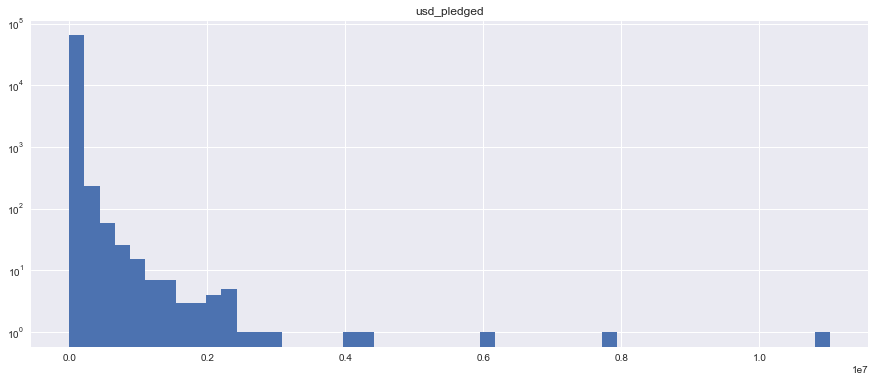

In [18]:
df_projects.hist(column='usd_pledged', bins=50)
plt.yscale('log')

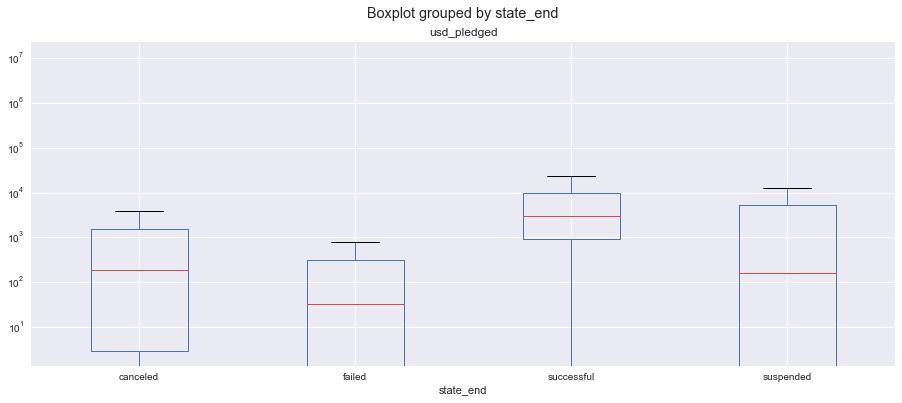

In [19]:
bp = df_projects.boxplot(column='usd_pledged', by='state_end')
plt.yscale('log')

#### backers_count_end

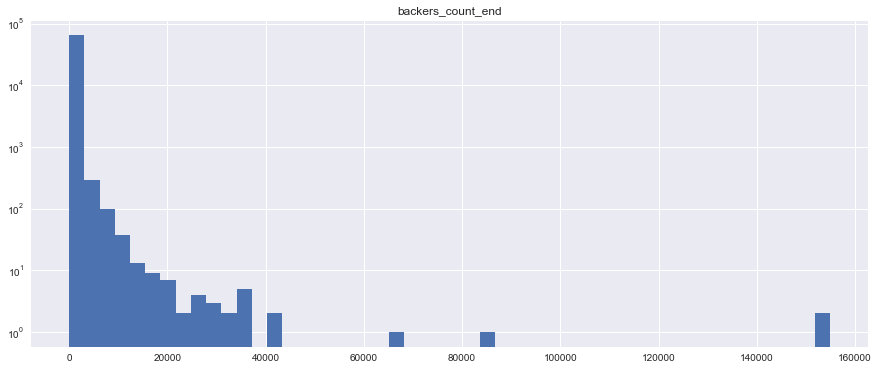

In [20]:
df_projects.hist(column='backers_count_end', bins=50)
plt.yscale('log')

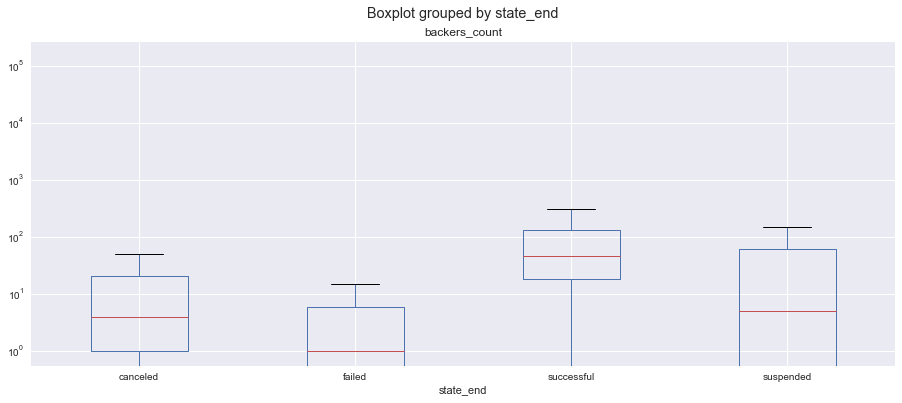

In [21]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

#### pledged_end

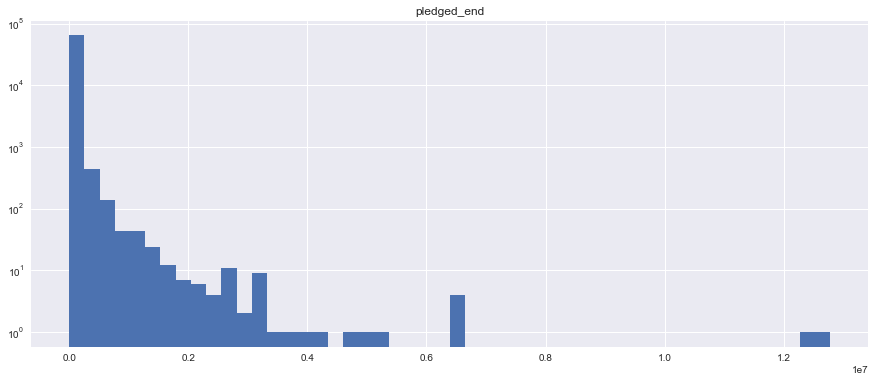

In [22]:
df_projects.hist(column='pledged_end', bins=50)
plt.yscale('log')

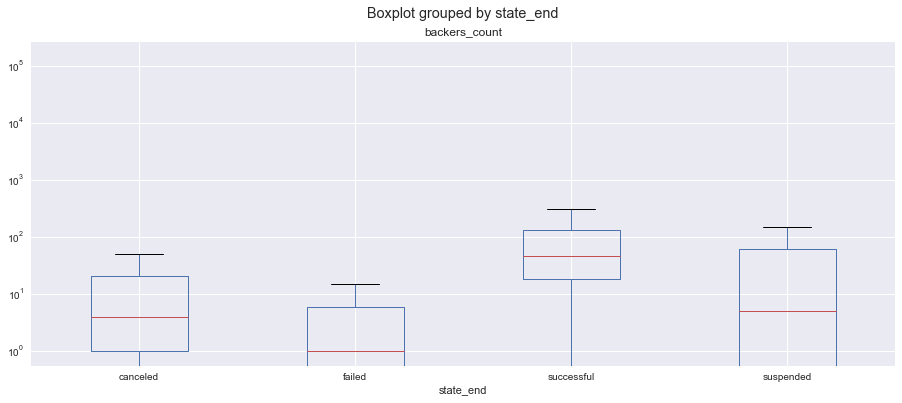

In [23]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

#### usd_pledged_end

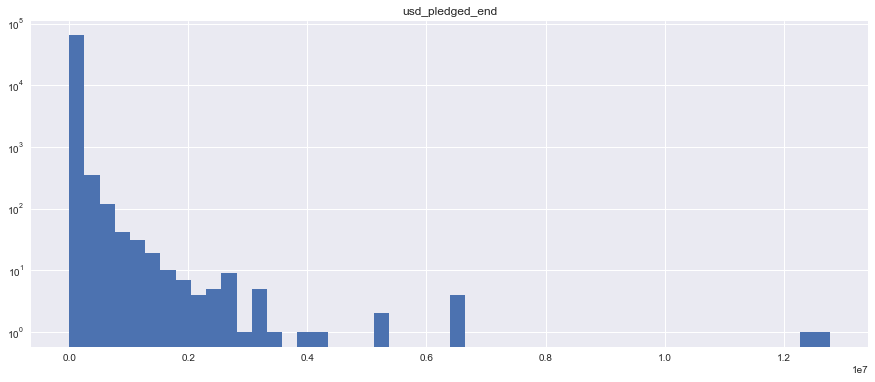

In [24]:
df_projects.hist(column='usd_pledged_end', bins=50)
plt.yscale('log')

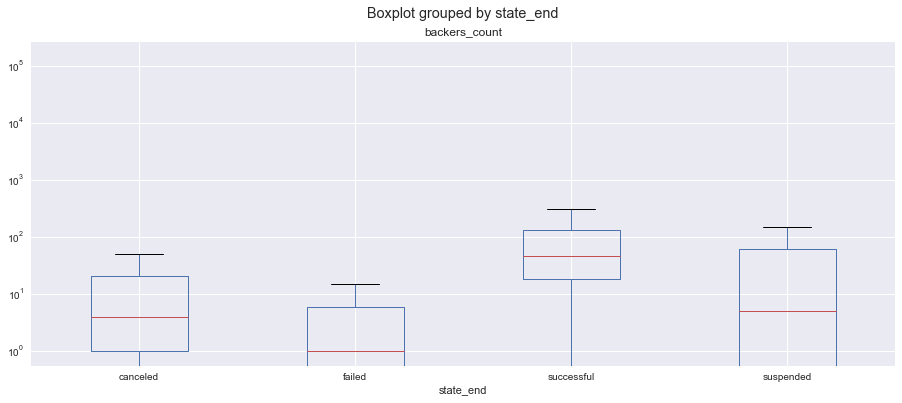

In [25]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

In [82]:
def print_corr_heatmap(cols):
    corr = df_projects[cols].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(corr, mask=mask, annot=True, square=True)

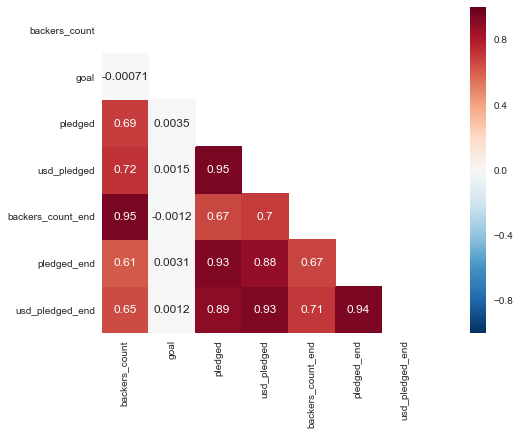

In [27]:
print_corr_heatmap(selected_cols)

All of seven variables have similar **long tale distribution**. Also pledged and usd_pledged equivalents are very similar which suggests that most of projects collected their money in USD. Let's look at categorical variables to find out.

### Categorical variables

In [28]:
df_projects = pd.read_csv('projects.csv', encoding='cp1252', index_col=0)

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
selected_cols = [
    'state_end',
    'currency_trailing_code',
    'disable_communication',
    'state',
    'spotlight',
    'disable_communication_end',
    'spotlight_end',
    'staff_pick',
    'staff_pick_end',
    'country',
    'currency',
    'currency_symbol'
]

In [30]:
df_projects[selected_cols].head()

,state_end,currency_trailing_code,disable_communication,state,spotlight,disable_communication_end,spotlight_end,staff_pick,staff_pick_end,country,currency,currency_symbol
0,successful,True,False,live,False,False,True,NaN,NaN,US,USD,$
1,failed,False,False,live,False,False,False,NaN,NaN,NL,EUR,€
2,failed,True,False,live,False,False,False,NaN,NaN,US,USD,$
3,successful,True,False,live,False,False,True,NaN,False,US,USD,$
4,successful,True,False,live,False,False,True,NaN,False,US,USD,$


In [31]:
def print_counts(cols):
    for col in cols:
        print('\n>>> '+col+':')
        print(df_projects[col].value_counts())

In [32]:
print_counts(selected_cols)


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication:
False    65038
Name: disable_communication, dtype: int64

>>> state:
live    65038
Name: state, dtype: int64

>>> spotlight:
False    65038
Name: spotlight, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    52537
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    55199
True      6150
Name: staff_pick_end, dtype: int64

>>> country:
US    43245
GB     6757
CA     3296
AU     1814
DE     1598
IT     1362
FR     1291
ES     1018
MX      854
NL      649
SE      569
CH      373
DK      330
BE      329
NZ      317
IE      265
AT      253


#### Dropping columns

In [33]:
# 'disable_communication' is always false
# 'state' is always live
# 'spotlight' is always false
# 'currency_symbol' carries the same information as currency and some values are not recognizable
remove_cols = ['disable_communication','state','spotlight','currency_symbol']
df_projects.drop(remove_cols, axis=1, inplace=True)

In [34]:
for col in remove_cols:
    selected_cols.remove(col)

In [35]:
print_counts(selected_cols[:-2])


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    52537
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    55199
True      6150
Name: staff_pick_end, dtype: int64


#### Handling missing values

In [36]:
df_projects[selected_cols].isnull().sum()

state_end                       0
currency_trailing_code          0
disable_communication_end       0
spotlight_end                   0
staff_pick                   7535
staff_pick_end               3689
country                         0
currency                        0
dtype: int64

In [37]:
# https://www.kickstarter.com/blog/introducing-projects-we-love-badges
# 'staff_pick' means 'has_badge' (projects we love)
# badges were added on Feb 2 2016
import time
timestamp = time.mktime(datetime.strptime('3/2/2016', "%d/%m/%Y").timetuple())
timestamp

1454454000.0

In [38]:
df_projects[df_projects['scraped_at']<timestamp]['staff_pick'].isnull().sum()

7535

In [39]:
df_projects[df_projects['scraped_at_end']<timestamp]['staff_pick_end'].isnull().sum()

3689

In [40]:
# values are missing due to the fact that badges did not exist before certain period
# therefore we can insert False to fill them
df_projects.loc[df_projects['staff_pick'].isnull(), 'staff_pick'] = False
df_projects.loc[df_projects['staff_pick_end'].isnull(), 'staff_pick_end'] = False
df_projects[selected_cols].isnull().sum()

state_end                    0
currency_trailing_code       0
disable_communication_end    0
spotlight_end                0
staff_pick                   0
staff_pick_end               0
country                      0
currency                     0
dtype: int64

In [41]:
print_counts(selected_cols[:-2])


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    60072
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    58888
True      6150
Name: staff_pick_end, dtype: int64


#### Updating dtypes

In [42]:
df_projects[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 8 columns):
state_end                    65038 non-null object
currency_trailing_code       65038 non-null bool
disable_communication_end    65038 non-null bool
spotlight_end                65038 non-null bool
staff_pick                   65038 non-null object
staff_pick_end               65038 non-null object
country                      65038 non-null object
currency                     65038 non-null object
dtypes: bool(3), object(5)
memory usage: 3.2+ MB


In [43]:
for col in selected_cols[1:-2]:
    df_projects[col] = df_projects[col].astype('bool')
df_projects[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 8 columns):
state_end                    65038 non-null object
currency_trailing_code       65038 non-null bool
disable_communication_end    65038 non-null bool
spotlight_end                65038 non-null bool
staff_pick                   65038 non-null bool
staff_pick_end               65038 non-null bool
country                      65038 non-null object
currency                     65038 non-null object
dtypes: bool(5), object(3)
memory usage: 2.3+ MB


#### Discovering correlations

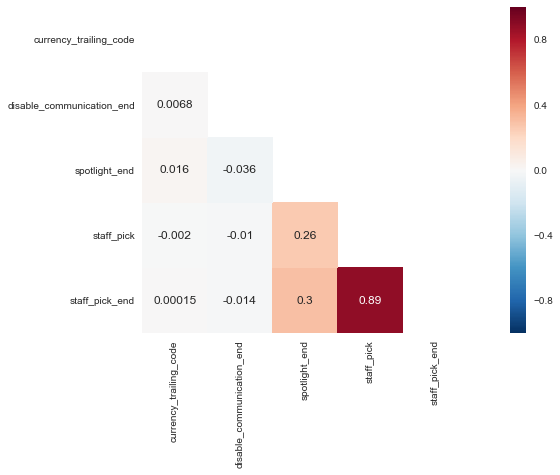

In [44]:
print_corr_heatmap(selected_cols[1:-2])

True

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022E1D6E4C50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022E25448EB8>]], dtype=object)

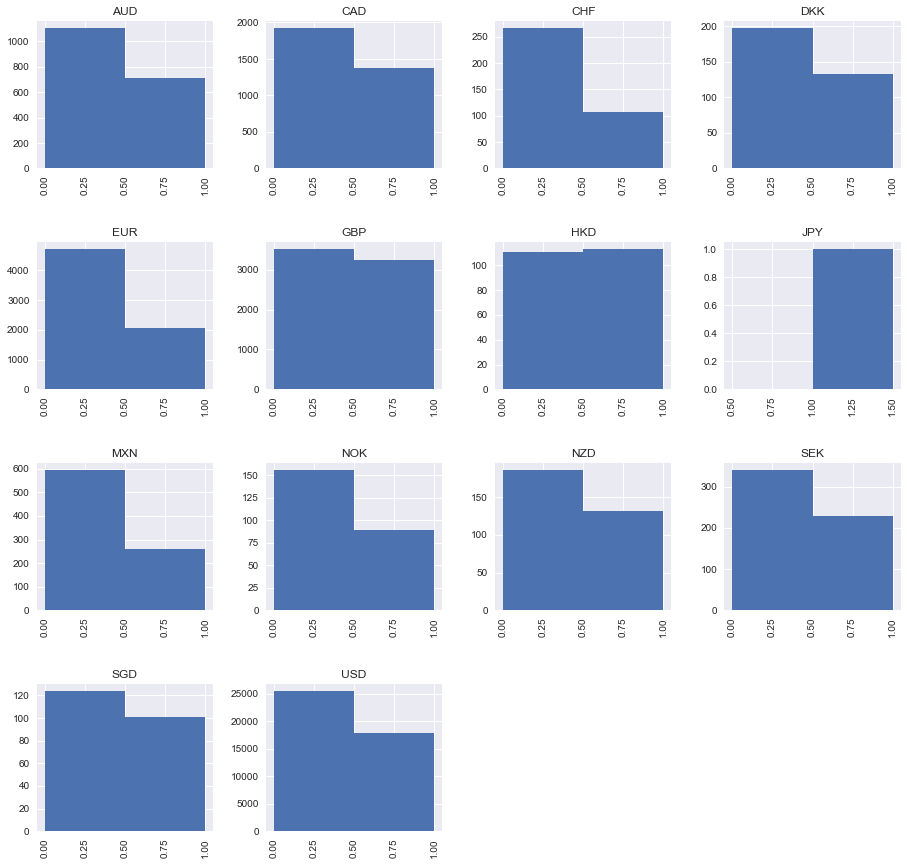

In [46]:
df_projects.hist(column='spotlight_end', bins=2, by='currency', figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022E24FCB4A8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022E277450F0>]], dtype=object)

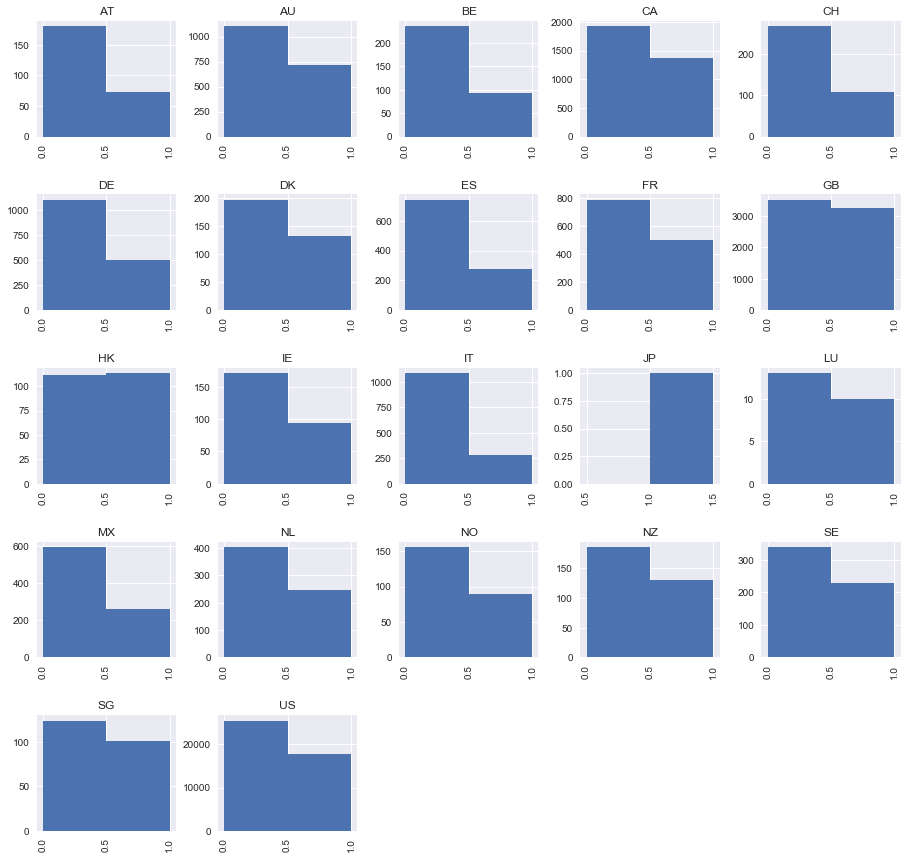

In [47]:
df_projects.hist(column='spotlight_end', bins=2, by='country', figsize=(15, 15))

As we can see, there is a difference in success rate of projects created in different countries or projects collecting money in different currencies. It will probably be helpfull to calculate these success rates for each category.